In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kplus_gps_1to3p5_Jul8_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
hists = {}


hists["hist_dau1_pdgID"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"PDG ID", 50, 0, 20)
                            )
hists["hist_dau2_pdgID"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"PDG ID", 50, 0, 20)
                            )
#25, -220, 3000
hists["hist_dau1_e"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"Energy [MeV]", 25, 0, 500)
                            )
hists["hist_dau2_e"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"Energy [MeV]", 25, 0, 500)
                            )
#25, 0, 3000
hists["hist_dau1_ke"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"Kinetic Energy [MeV]", 25, 0, 500)
                            )
hists["hist_dau2_ke"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"Kinetic Energy [MeV]", 25, 0, 500)
                            )
#25, 0, 3000


In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_Particle']
    sim_particle_n = ldmx_events['n']['Sim_Particle']
    sim_particle_dau1 = ldmx_events['Sim_Particle_dau1']
    sim_particle_dau2 = ldmx_events['Sim_Particle_dau2']
    
    
    masks_id = {#'Kplus': 321,
                #'Kshort': 310,
                #'Kminus': -321,
                'Electron': 11,
                'NuMuplus': 14,
                #'NuMuminus': -14,
                #'NuMuplus': 12,
                #'NuMuminus': -12,
                #'Piplus': 211,
                #'Piminus': -211,
                #'Muminus': 13,
                #'Muplus': -13,
                #'Proton':2212,
                #'Neutron':2112,
               }
    masses = {#'Kplus': 493.677,
              #'Kshort': 493.677,
              #'Kminus': 493.677,
              'Electron': 0.51099895,
              'NuMuplus': 0,
              #'NuMuminus': 0,
              #'NuEplus': 0,
              #'NuEminus': 0,
              #'Piplus': 139.57039,
              #'Piminus': 139.57039,
              #'Muminus': 105.658,
              #'Muplus': 105.658,
              #'Proton': 939.565,
              #'Neutron': 939.565,
              }

    decay1_mask = (flat(sim_particle_dau1.momdecay)==8)
    decay2_mask = (flat(sim_particle_dau2.momdecay)==8)
  
    dau1 = get_vector(sim_particle_dau1[decay1_mask])
    dau2 = get_vector(sim_particle_dau2[decay2_mask])
    
    for part,pmask in masks_id.items():
        part_mask1 = (sim_particle_dau1[decay1_mask].pdgID == pmask)
        hists["hist_dau1_e"].fill(Ptype= part,
                                     e=flat(sim_particle_dau1[decay1_mask].e[part_mask1]),
                                     )   
        hists["hist_dau1_ke"].fill(Ptype= part,
                                     e=flat(sim_particle_dau1[decay1_mask].e[part_mask1]) - masses[part],
                                     )   
        hists["hist_dau1_pdgID"].fill(Ptype= part,
                                     e=flat(sim_particle_dau1[decay1_mask].pdgID[part_mask1]),
                                     )  
        part_mask2 = (sim_particle_dau2[decay2_mask].pdgID == pmask)
        hists["hist_dau2_e"].fill(Ptype= part,
                                     e=flat(sim_particle_dau2[decay2_mask].e[part_mask2]),
                                     )  
        hists["hist_dau2_ke"].fill(Ptype= part,
                                     e=flat(sim_particle_dau2[decay2_mask].e[part_mask2]) - masses[part],
                                     )   
        hists["hist_dau2_pdgID"].fill(Ptype= part,
                                     e=flat(sim_particle_dau2[decay2_mask].pdgID[part_mask2]),
                                     )
    print(flat(sim_particle_dau1[decay1_mask].pdgID))
    print(flat(sim_particle_dau2[decay2_mask].pdgID))

In [6]:
nchunk = 0
for chunk in ldmx_dict:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
[11.]
[]
process 2
[11.]
[]
process 3
[]
[11.]
process 4
[11. 11. 14. 11.]
[11.]
process 5
[11.]
[]


In [7]:
#print(hists["hist_dau1_e"])
#fig, ax = plt.subplots()
#hist.plot1d(hists["hist_dau1_e"],ax=ax,clear=False);
#leg = ax.legend([r'$e^-$', r'$K^-$', r'$K^+$', r'$\nu_\mu$', r'$\pi^-$', r'$\pi^+$'])
#ax.text(10, 4.5, 'Decay2')

#fig, ax = plt.subplots()
#hist.plot1d(hists["hist_dau1_ke"],ax=ax,clear=False);
#leg = ax.legend([r'$e^-$', r'$K^-$', r'$K^+$', r'$\nu_\mu$', r'$\pi^-$', r'$\pi^+$'])
#ax.text(10, 4.5, 'Decay2')

#fig, ax = plt.subplots()
#hist.plot1d(hists["hist_dau1_pdgID"]+hists["hist_dau1_pdgID"],ax=ax,clear=False);
#leg = ax.legend([r'$e^-$', r'$K^-$', r'$K^+$',r'$\mu^-$', r'$\mu^+$', r'$\nu_\mu$', r'$\pi^-$', r'$\pi^+$' ])
#ax[2].text(5, 40, 'Decay4')


<Hist (Ptype,e) instance at 0x10ef33f10>


Text(1, 11.5, 'Decay 8')

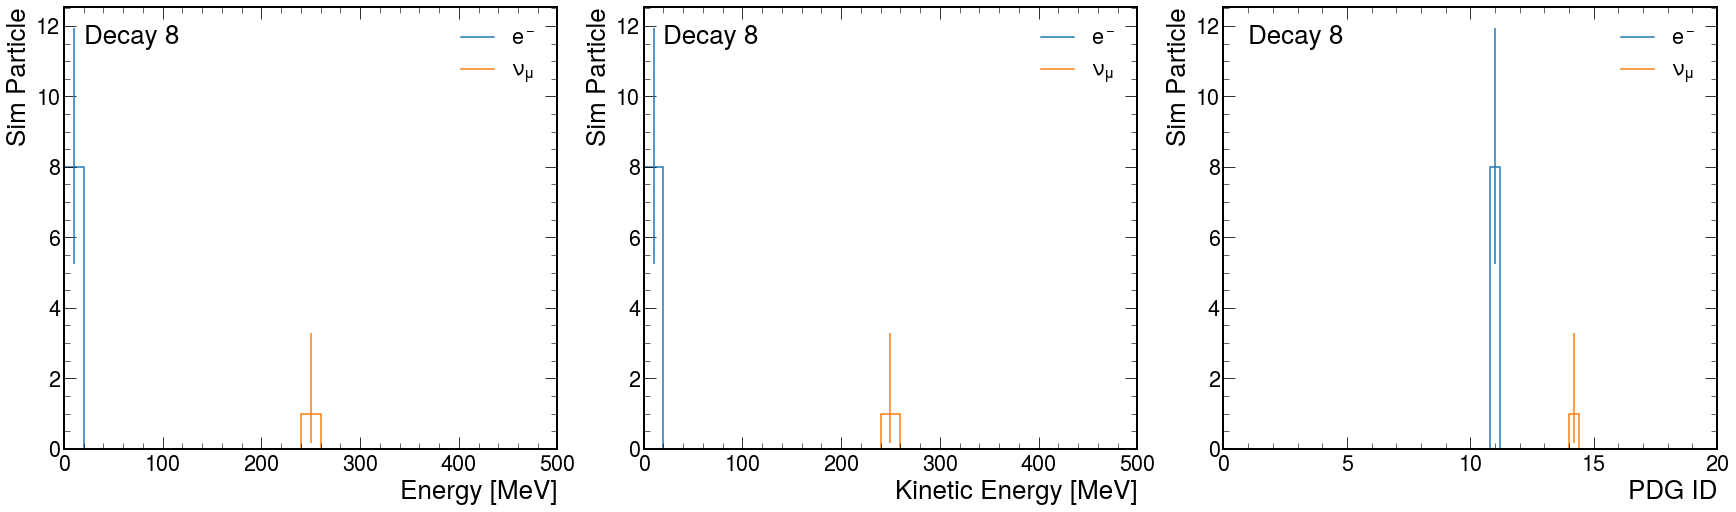

In [14]:
print(hists["hist_dau1_e"])
fig, ax = plt.subplots(1,3, figsize=(24,7), constrained_layout=True)
hist.plot1d(hists["hist_dau1_e"]+hists["hist_dau2_e"],ax=ax[0],clear=False);
leg = ax[0].legend([r'$e^-$',r'$\nu_\mu$'])
#ax[0].text(70, 4.5, 'Decay 1')
#ax[0].text(50, 17, 'Decay 2')
#ax[0].text(50, 12.7, 'Decay 7')
ax[0].text(20, 11.5, 'Decay 8')

hist.plot1d(hists["hist_dau1_ke"]+hists["hist_dau2_ke"],ax=ax[1],clear=False);
leg = ax[1].legend([r'$e^-$',r'$\nu_\mu$'])
#ax[1].text(70, 4.5, 'Decay 1')
#ax[1].text(50, 17, 'Decay 2')
#ax[1].text(50, 12.7, 'Decay 7')
ax[1].text(20, 11.5, 'Decay 8')

hist.plot1d(hists["hist_dau1_pdgID"]+hists["hist_dau2_pdgID"],ax=ax[2],clear=False);
leg = ax[2].legend([r'$e^-$',r'$\nu_\mu$'])
#ax[2].text(-200, 4.5, 'Decay 1')
#ax[2].text(100, 17, 'Decay 2')
#ax[2].text(50, 12.7, 'Decay 7')
ax[2].text(1, 11.5, 'Decay 8')




#decay 1: legend([r'$e^-$',r'$K_s$', r'$\nu_\mu$',r'$\pi^-$'])
#decay 2: legend([r'$e^-$',r'$\mu^+$',r'$\pi^-$',  r'$p^+$'])
#decay 7: legend([r'$e^-$',r'$\nu_\mu$',r'$\pi^+$',  r'$p^+$'])
#decay 8: legend([r'$e^-$',r'$\nu_\mu$'])

